## Fruit Image Classifier - Part 1: Imports & Preprocessing


In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Fix random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")


#### Detect GPU Available and its Details

In [ ]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

### Define dataset path and categories

In [4]:
DATASET_DIR = "dataset"  # Root dataset folder

SPLITS = ["training", "validation", "test"]

# Your main fruit categories
CATEGORIES = ["Apple", "Banana", "Grapes", "Mango", "Orange"]

# Image size expected for ResNet50
IMG_SIZE = (224, 224)

# Empty lists for data and labels
data_splits = {}
labels_splits = {}

### Load and preprocess images

In [5]:
for split in SPLITS:
    split_data = []
    split_labels = []
    split_path = os.path.join(DATASET_DIR, split)

    print(f"\n📂 Loading {split} data...")

    for category in CATEGORIES:
        category_path = os.path.join(split_path, category)

        # Loop through subfolders (e.g., apple rotten/, apple eaten/)
        for subfolder in os.listdir(category_path):
            subfolder_path = os.path.join(category_path, subfolder)
            if not os.path.isdir(subfolder_path):
                continue

            for img_name in tqdm(os.listdir(subfolder_path), desc=f"{split}/{category}/{subfolder}"):
                img_path = os.path.join(subfolder_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        continue
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, IMG_SIZE)
                    img = img.astype(np.float32) / 255.0

                    split_data.append(img)
                    split_labels.append(category)
                except Exception as e:
                    print(f"⚠️ Error loading {img_path}: {e}")

    data_splits[split] = np.array(split_data)
    labels_splits[split] = np.array(split_labels)

    print(f"✅ {split} images loaded: {len(split_data)}")
    print(f"📐 {split} shape: {data_splits[split].shape}")


📂 Loading training data...


training/Orange/ripe orange: 100%|██████████| 193/193 [00:00<00:00, 311.85it/s]


✅ training images loaded: 23766
📐 training shape: (23766, 224, 224, 3)

📂 Loading validation data...


validation/Orange/orange fruit: 100%|██████████| 40/40 [00:01<00:00, 20.11it/s]


✅ validation images loaded: 6451
📐 validation shape: (6451, 224, 224, 3)

📂 Loading test data...


test/Orange/orange fruit: 100%|██████████| 40/40 [00:02<00:00, 19.04it/s]


✅ test images loaded: 6365
📐 test shape: (6365, 224, 224, 3)


In [6]:
### Encode labels

In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Fit encoder only once (using training labels)
label_encoder = LabelEncoder()
label_encoder.fit(labels_splits["training"])

# Encode all splits
y_train = to_categorical(label_encoder.transform(labels_splits["training"]))
y_val = to_categorical(label_encoder.transform(labels_splits["validation"]))
y_test = to_categorical(label_encoder.transform(labels_splits["test"]))

X_train = data_splits["training"]
X_val = data_splits["validation"]
X_test = data_splits["test"]

print("\n🏷️ Label mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {i}: {label}")


🏷️ Label mapping:
  0: Apple
  1: Banana
  2: Grapes
  3: Mango
  4: Orange


### Show Sample Images

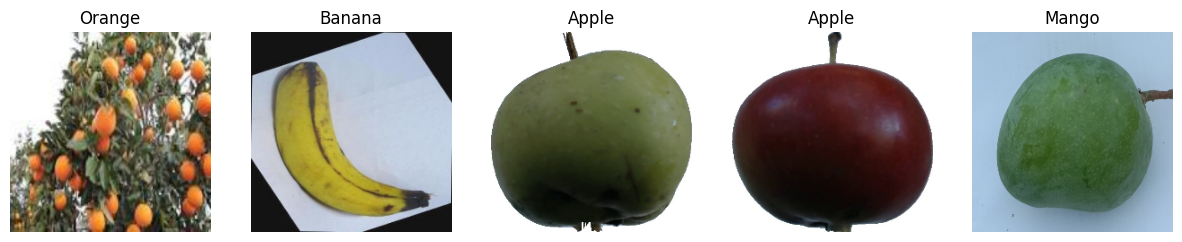

In [8]:
def show_sample_images(X, y, encoder, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        idx = np.random.randint(0, len(X))
        plt.subplot(1, n, i+1)
        plt.imshow(X[idx])
        plt.title(encoder.inverse_transform([np.argmax(y[idx])])[0])
        plt.axis("off")
    plt.show()

show_sample_images(X_train, y_train, label_encoder)

### Part 2: Data Augmentation

After successfully loading and preprocessing our dataset in **Part 1**, the next steps are to:

1. **Apply data augmentation** to make the model more robust and reduce overfitting.  
2. **Prepare the data generators** that will feed the model efficiently.


### 📸 Data Augmentation

To make the model generalize better, we apply small random transformations to the training images:

- **Rotation:** up to ±20°  
- **Shifting:** horizontally or vertically up to 10%  
- **Zooming:** up to 20%  
- **Horizontal flip:** mirrors images to simulate variations

These augmentations are applied **on the fly** during training.


In [9]:
# Part 2: Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training set only
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()  # no augmentation on validation data
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32, shuffle=False)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

print("✅ Data augmentation ready.")


✅ Data augmentation ready.


### Visualize Augmented Images (Optional)

Before moving to model training, it’s a good idea to visualize a few augmented samples to ensure the transformations look correct.


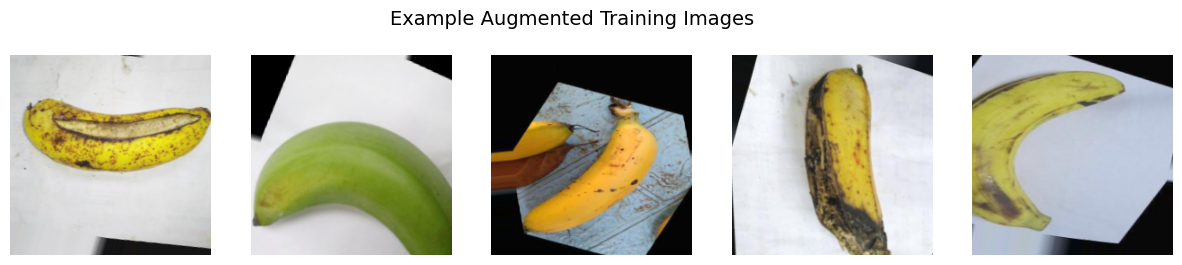

In [10]:
import matplotlib.pyplot as plt

augmented_images, _ = next(train_generator)
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(augmented_images[i])
    plt.axis("off")
plt.suptitle("Example Augmented Training Images", fontsize=14)
plt.show()

## Part 3 — Model Building (Transfer Learning)

### Step 1: Import the required libraries

In [11]:
# Import the required libraries
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam

### Step 2: Load the Pre-trained Model (ResNet50)

In [12]:
# Number of classes
num_classes = len(label_encoder.classes_)

# Load pre-trained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False


### Step 3: Build the Classification Head

In [13]:
# Create new model on top of base
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


### Step 4: Compile the Model

In [14]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,629 (90.98 MB)

 Trainable params: 262,917 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

📝 Why categorical_crossentropy?
Because your labels are one-hot encoded (y_train and y_test).

### Step 5: Preprocess and Prepare Data for Training

In [15]:
# Preprocess the data
print("🔄 Preprocessing training data...")
X_train_prep = preprocess_input(X_train)
print("✅ Training data preprocessing complete.")

print("🔄 Preprocessing test data...")
X_test_prep = preprocess_input(X_test)
print("✅ Test data preprocessing complete.")

🔄 Preprocessing training data...
✅ Training data preprocessing complete.
🔄 Preprocessing test data...
✅ Test data preprocessing complete.


### Step 6: Data Augmentation (Optional)

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

datagen.fit(X_train_prep)


## Model Training

In [ ]:
import tensorflow as tf
import time
from tensorflow.keras.callbacks import Callback


# ✅ Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    device_name = '/GPU:0'
    print(f"✅ Training on GPU: {gpus[0]}")
else:
    device_name = '/CPU:0'
    print("⚠️ No GPU detected — training on CPU.")


# Custom callback to measure time per epoch
class TimeHistory(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        print(f"⏱️ Time for epoch {epoch + 1}: {epoch_time:.2f} seconds")

# Instantiate the callback
time_callback = TimeHistory()


# Model training

batch_size = 32
epochs = 20

with tf.device(device_name):
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[time_callback],
        verbose=1       # Show progress bar with each epoch
    )

⚠️ No GPU detected — training on CPU.


C:\Users\K1taru\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4799 - loss: 1.2955⏱️ Time for epoch 1: 1309.67 seconds
743/743 ━━━━━━━━━━━━━━━━━━━━ 1310s 2s/step - accuracy: 0.5779 - loss: 1.1005 - val_accuracy: 0.7755 - val_loss: 0.6139
Epoch 2/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6985 - loss: 0.8497⏱️ Time for epoch 2: 1378.86 seconds
743/743 ━━━━━━━━━━━━━━━━━━━━ 1379s 2s/step - accuracy: 0.7143 - loss: 0.8095 - val_accuracy: 0.9040 - val_loss: 0.5272
Epoch 3/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7564 - loss: 0.6977⏱️ Time for epoch 3: 1286.64 seconds
743/743 ━━━━━━━━━━━━━━━━━━━━ 1287s 2s/step - accuracy: 0.7631 - loss: 0.6727 - val_accuracy: 0.9257 - val_loss: 0.5292
Epoch 4/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7923 - loss: 0.6032⏱️ Time for epoch 4: 1279.71 seconds
743/743 ━━━━━━━━━━━━━━━━━━━━ 1280s 2s/step - accuracy: 0.7975 - loss: 0.5914 - val_accuracy: 0.9141 - val_loss: 0.6156
Epoch 5/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 

✅ More epochs → the model learns more patterns.

⚠️ But too many epochs can lead to overfitting — when the model memorizes the training data and performs poorly on new data.

Too few epochs can lead to underfitting — when the model hasn’t learned enough.

📝 Tip: Start with 10–20 epochs, then increase if the model is still improving.

## Part 4: Model Evaluation and Visualization
After training the model, it’s important to evaluate its performance and visualize how well it learned over time. This helps us determine if the model is underfitting, overfitting, or performing as expected.

### 📊 1. Evaluating the Model

We use the test dataset to check how well the model performs on unseen data.
This gives us metrics like accuracy and loss, which reflect how close the model’s predictions are to the actual labels.

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


### Plotting Training Accuracy and Loss

During training, we stored the accuracy and loss values for each epoch.
Plotting them helps us visualize how the model improved over time.

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


📝 Interpretation Tips:

📈 If training accuracy is much higher than validation accuracy → overfitting.

📉 If both are low → underfitting.

✅ If both curves improve smoothly and are close → good training.

### 3. Confusion Matrix

A confusion matrix provides a more detailed view of classification results.
It shows how many times the model correctly predicted each class versus how many times it confused it with another.

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions on test set
y_true = np.argmax(y_test, axis=1)  # true labels from encoded test set
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()


🧠 How to read the confusion matrix:

Diagonal values = correct predictions ✅

Off-diagonal values = misclassifications ❌

A perfect model would have non-zero values only along the diagonal.